In [0]:
import sklearn
import numpy as np 
import pandas as pd
from sklearn import preprocessing
from imblearn.ensemble import BalancedBaggingClassifier 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")


**`Loading training data.`**

In [0]:
df = pd.read_csv("/content/credit_card_default_train.csv")
test_data= pd.read_csv("/content/credit_card_default_test.csv")

In [0]:
df = df.iloc[:,1:]
test_data_ = test_data.iloc[:,1:]

**Custom Label Encoder**

In [0]:
def encoder(feature, classes):
  return classes.index(feature)+1

In [0]:
#training data
EDUCATION_STATUS_Classes = list(df['EDUCATION_STATUS'].value_counts().index)
MARITAL_STATUS_Classes = list(df['MARITAL_STATUS'].value_counts().index)
Gender_Classes = list(df['Gender'].value_counts().index)
AGE_Classes = list(df['AGE'].value_counts().index)

#test_data
EDUCATION_STATUS_Classes = list(test_data_['EDUCATION_STATUS'].value_counts().index)
MARITAL_STATUS_Classes = list(test_data_['MARITAL_STATUS'].value_counts().index)
Gender_Classes = list(test_data_['Gender'].value_counts().index)
AGE_Classes = list(test_data_['AGE'].value_counts().index)

In [0]:
#training data
df["EDUCATION_STATUS"] = df["EDUCATION_STATUS"].apply(lambda feature: encoder( feature, EDUCATION_STATUS_Classes))
df["MARITAL_STATUS"] = df["MARITAL_STATUS"].apply(lambda feature: encoder( feature, MARITAL_STATUS_Classes))
df["Gender"] = df["Gender"].apply(lambda feature: encoder( feature, Gender_Classes))
df["AGE"] = df["AGE"].apply(lambda feature: encoder( feature, AGE_Classes))
#test data
test_data_["EDUCATION_STATUS"] = test_data_["EDUCATION_STATUS"].apply(lambda feature: encoder( feature, EDUCATION_STATUS_Classes))
test_data_["MARITAL_STATUS"] = test_data_["MARITAL_STATUS"].apply(lambda feature: encoder( feature, MARITAL_STATUS_Classes))
test_data_["Gender"] = test_data_["Gender"].apply(lambda feature: encoder( feature, Gender_Classes))
test_data_["AGE"] = test_data_["AGE"].apply(lambda feature: encoder( feature, AGE_Classes))

In [85]:
df.head(10)

,Balance_Limit_V1,Gender,EDUCATION_STATUS,MARITAL_STATUS,AGE,PAY_JULY,PAY_AUG,PAY_SEP,PAY_OCT,PAY_NOV,PAY_DEC,DUE_AMT_JULY,DUE_AMT_AUG,DUE_AMT_SEP,DUE_AMT_OCT,DUE_AMT_NOV,DUE_AMT_DEC,PAID_AMT_JULY,PAID_AMT_AUG,PAID_AMT_SEP,PAID_AMT_OCT,PAID_AMT_NOV,PAID_AMT_DEC,NEXT_MONTH_DEFAULT
0,1M,1,2,1,1,-1,-1,-1,-1,-1,-1,3248,3389,6004,39418,162772,-13982,3437,6004,39418,162772,0,538165,0
1,1M,2,3,1,2,0,-1,-1,-1,-1,0,353351,151818,26948,43530,80811,124590,151818,46200,43530,80811,942,33666,0
2,100K,2,3,2,1,4,3,2,2,-2,-2,16681,16082,15477,0,0,0,0,0,0,0,0,0,1
3,200K,2,2,2,1,2,0,0,0,0,0,90457,92848,95193,97309,100353,102740,3855,3890,3696,4620,4049,3918,1
4,1M,2,2,1,1,2,2,0,0,0,0,429556,419466,429785,435354,445271,453899,0,20790,16170,17325,16401,17325,0
5,400K,2,2,2,1,0,0,0,0,0,0,361284,364802,366703,353910,356117,358845,16632,18480,12728,13398,13860,12705,0
6,100K,1,1,2,2,1,2,2,2,2,2,8991,8515,11698,11173,12030,12647,0,3696,0,1386,1155,0,0
7,100K,2,3,1,2,2,2,2,0,0,2,51836,55828,54241,55325,59272,57976,5521,0,1984,4844,0,2523,1
8,500K,1,1,1,1,0,0,0,2,0,0,198579,204634,218092,212970,213654,217992,9240,17325,0,6930,11550,11550,0
9,1M,1,1,2,3,0,0,2,0,0,0,268551,282726,274123,221148,222936,224276,26565,0,8184,8547,8194,7311,0


In [86]:
test_data_.head(10)

,Balance_Limit_V1,Gender,EDUCATION_STATUS,MARITAL_STATUS,AGE,PAY_JULY,PAY_AUG,PAY_SEP,PAY_OCT,PAY_NOV,PAY_DEC,DUE_AMT_JULY,DUE_AMT_AUG,DUE_AMT_SEP,DUE_AMT_OCT,DUE_AMT_NOV,DUE_AMT_DEC,PAID_AMT_JULY,PAID_AMT_AUG,PAID_AMT_SEP,PAID_AMT_OCT,PAID_AMT_NOV,PAID_AMT_DEC
0,500K,1,1,2,1,0,0,0,0,0,0,194188,198510,128316,311201,351790,352206,13710,12816,195701,53246,17256,12991
1,200K,2,1,2,1,0,0,0,0,0,0,87115,89427,91823,94181,97221,100275,3756,3842,3890,4620,4620,4620
2,400K,1,1,1,2,-1,-1,2,0,0,-1,2693,9573,8984,11294,9561,993,6930,0,2310,0,2310,40060
3,1.5M,1,2,2,1,1,-1,-1,-2,-2,-2,0,5775,5775,0,0,0,5775,5775,0,0,0,0
4,100K,2,3,1,2,0,0,-2,-2,-2,-2,85257,0,0,0,0,0,0,0,0,0,0,0
5,100K,2,1,1,2,0,0,0,0,0,0,45040,30159,32553,24195,25867,28177,4620,2897,2310,1672,2310,2310
6,200K,2,3,1,2,2,2,2,2,2,2,125962,122760,124236,117768,119519,113333,4158,9009,693,7854,0,9240
7,500K,1,1,2,1,0,0,0,-2,-2,-2,22419,5013,0,0,0,0,2310,0,0,0,0,0
8,500K,1,1,1,2,-1,-1,-1,-1,-1,-1,6893,356,4876,2372,1377,1361,356,4886,2372,1377,1361,2576
9,400K,2,1,2,3,0,0,0,0,0,0,298103,145759,133287,123141,112548,112800,6930,4851,5775,4851,4851,3465


In [0]:
def normalize_Balance_Limit_V1( balance ):
  #function to format balance limit values
    if balance[-1] == "K":
        balance = eval(balance[:-1])*1000
    else:
        balance = eval(balance[:-1])*1000000
    return balance

In [0]:
df["Balance_Limit_V1"] = df["Balance_Limit_V1"].apply(lambda balance: normalize_Balance_Limit_V1( balance ))
test_data_["Balance_Limit_V1"] = test_data_["Balance_Limit_V1"].apply(lambda balance: normalize_Balance_Limit_V1( balance ))

**General Dataset Analysis**


No of possitive samples :  5330
No of negative samples :  18670


Text(0, 0.5, 'samples')

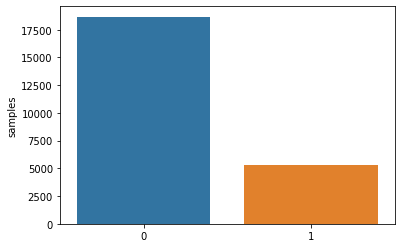

In [165]:
print("No of possitive samples : ", len(df.loc[df["NEXT_MONTH_DEFAULT"]==1]))
print("No of negative samples : ", len(df.loc[df["NEXT_MONTH_DEFAULT"]==0]))
target = df.NEXT_MONTH_DEFAULT.value_counts()
sns.barplot(target.index, target)
plt.gca().set_ylabel('samples') #gca - gets current axis of current figure

**Selecting features based on correlation.** 

Generating the correlation matrix

In [0]:
def correlation_heatmap(data):
    correlations = data.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=False, cbar_kws={"shrink": 1.0})
    plt.show()
    return correlations


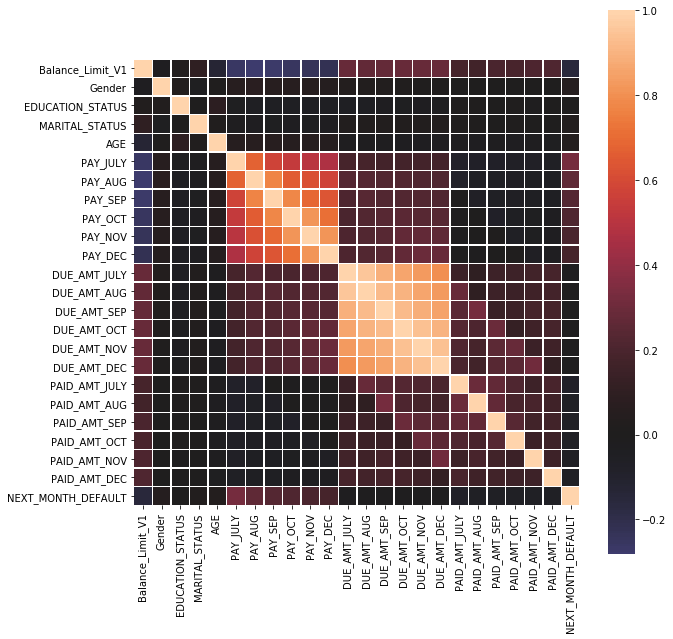

In [91]:
correlations = correlation_heatmap(df)

*Removing features which has high co-relation (0.9) with other features*

In [0]:
columns = np.full((correlations.shape[0],), True, dtype=bool)
for i in range(correlations.shape[0]):
    for j in range(i+1, correlations.shape[0]):
        if correlations.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = df.columns[columns]
data = data[selected_columns]
test_data_fe = test_data_[selected_columns[:-1]]


In [93]:
test_data_fe.columns

Index(['Balance_Limit_V1', 'Gender', 'EDUCATION_STATUS', 'MARITAL_STATUS',
       'AGE', 'PAY_JULY', 'PAY_AUG', 'PAY_SEP', 'PAY_OCT', 'PAY_NOV',
       'PAY_DEC', 'DUE_AMT_JULY', 'PAID_AMT_JULY', 'PAID_AMT_AUG',
       'PAID_AMT_SEP', 'PAID_AMT_OCT', 'PAID_AMT_NOV', 'PAID_AMT_DEC'],
      dtype='object')

In [0]:
#training data
x1 = data.iloc[:,:-1]
x1_norm = data.iloc[:,:-1]
y1 = data["NEXT_MONTH_DEFAULT"]
X_train_ori = df.iloc[:, :-1]

#test_data
x1_test = test_data_fe
x1_test_norm  = test_data_fe
X_test_ori = test_data_

**Standardising features to have a mean = 0 and SD = 1**


In [0]:
standardScaler = preprocessing.StandardScaler()
for feature in x1_norm.columns:
  x1_norm[feature]= standardScaler.fit_transform(x1_norm[feature].values.reshape(-1,1))
  x1_test_norm[feature]= standardScaler.fit_transform(x1_test_norm[feature].values.reshape(-1,1))

**Dividing the dataset into train and test sets.**

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
...     x1, y1, test_size=0.2, random_state=42)

In [0]:
X_train_std, X_test_std, y_train, y_test = train_test_split(
...     x1_norm, y1, test_size=0.2, random_state=42) #standardised training data

In [0]:
X_train_ori_, X_test_ori_, y_train_ori_, y_test_ori_ = train_test_split(
...     X_train_ori, y1, test_size=0.2, random_state=42)

In [98]:
clf = RandomForestClassifier(random_state=41)
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=41, verbose=0,
                       warm_start=False)

In [0]:
y_pred = clf.predict(X_test)
score = clf.score(X_test,y_test)
report = classification_report(y_test, y_pred)
print("Score : %{} using {}".format(score*100, 'RandomForestClassifier'))
print(report)

In [0]:
Y_test_pred = clf2.predict(x1_test)

In [0]:
output = pd.DataFrame( data = {'Client_ID': test_data['Client_ID'], 'NEXT_MONTH_DEFAULT': Y_test_pred})
output.to_csv("/content/Submission1.csv", index = False, quoting=3)
    

**Testing Out Balanced Bagging Classifier with Random forest and PCA**

**Utils**

In [0]:
def get_feature_importance(clsf, ftrs):
    imp = clsf.feature_importances_.tolist()
    feat = ftrs
    result = pd.DataFrame({'feature':feat,'score':imp})
    result = result.sort_values(by=['score'],ascending=False)
    return result

In [0]:
def classification( classifier , X_train, X_test, Y_train, Y_test):
  classifier.fit(X_train, Y_train)
  y_pred = classifier.predict(X_test)
  score  = classifier.score(X_test,Y_test)
  report = classification_report(Y_test, y_pred)
  cm     = confusion_matrix(Y_test, y_pred)
  return score, report, cm

**RandomizedSearchCV for optimal Parameters**

In [0]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 30, num = 15)]
max_depth.append(None)
# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(2, 50, num = 25)]
# Minimum number of samples to split an internal node
min_samples_split = [int(x) for x in np.linspace(2, 100, num = 50)]
skf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=268)
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf,
               'min_samples_split' : min_samples_split,
               'n_jobs' : [-1],
               'random_state' : [42]}

In [0]:
grid_forest = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = random_grid, 
                               n_iter = 50, cv = skf, random_state=42, n_jobs = -1,
                                scoring = 'accuracy')

In [0]:
grid_forest.fit(X_train, y_train)

#let's see the best estimator
best_forest = grid_forest.best_estimator_
print(best_forest)
print("_"*40)
#with its score
print("Cross-validated best score {}%".format(round(grid_forest.best_score_ * 100,3)))
#score on test
predictions = best_forest.predict(X_test)

Different Classifiers

In [0]:
RF = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=14, min_samples_split=72,
                       min_weight_fraction_leaf=0.0, n_estimators=115,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False) #from RandomizedSearch

In [0]:
XGB  = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=381,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)


In [0]:
BBC = BalancedBaggingClassifier( base_estimator = RF, random_state=0 )

In [0]:
score , report, cm = classification( BBC , X_train, X_test, y_train, y_test)

In [193]:
print(report)

              precision    recall  f1-score   support

           0       0.89      0.82      0.85      3745
           1       0.50      0.64      0.56      1055

    accuracy                           0.78      4800
   macro avg       0.70      0.73      0.71      4800
weighted avg       0.80      0.78      0.79      4800

